In [65]:
import pandas as pd
import datetime
import numpy as np

In [66]:
log_df = pd.read_csv("./7.recommendation/access_log.csv", parse_dates=['date'])
log_df.head()

,user_id,item_id,date
0,4,205587,2015-07-04
1,4,748683,2015-07-04
2,4,790055,2015-07-04
3,4,790055,2015-07-04
4,4,764638,2015-07-04


In [67]:
log_df['user_id'].value_counts().describe()

count    31443.000000
mean        10.365042
std         16.023399
min          2.000000
25%          3.000000
50%          5.000000
75%         11.000000
max        632.000000
Name: count, dtype: float64

In [68]:
log_df['item_id'].value_counts().describe()

count    87611.000000
mean         3.719944
std          8.802572
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        941.000000
Name: count, dtype: float64

In [69]:
log_df['date'].value_counts().describe()

count        8.000000
mean     40738.500000
std       4895.105106
min      33311.000000
25%      38431.500000
50%      41868.500000
75%      44470.750000
max      45441.000000
Name: count, dtype: float64

In [70]:
log_df

,user_id,item_id,date
0,4,205587,2015-07-04
1,4,748683,2015-07-04
2,4,790055,2015-07-04
3,4,790055,2015-07-04
4,4,764638,2015-07-04
...,...,...,...
325903,424168,454500,2015-07-01
325904,424168,189002,2015-07-01
325905,424168,1020948,2015-07-01
325906,424168,96441,2015-07-04


In [71]:
start_date = datetime.datetime(2015, 7, 1)
end_date = datetime.datetime(2015, 7, 7)
target_date = datetime.datetime(2015, 7, 8)

In [72]:
x_df = log_df[log_df["date"].between(start_date, end_date)]
y_df = log_df[log_df["date"] == target_date]

In [73]:
x_df["diff_days"] = (target_date - x_df["date"]).dt.days
UI2RF_df = x_df.groupby(["user_id", "item_id"]).agg(rcen=("diff_days", "min"), freq=("date", "count")).reset_index()

C:\Users\ryoga.misu\AppData\Local\Temp\ipykernel_19124\3884218940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df["diff_days"] = (target_date - x_df["date"]).dt.days


In [74]:
UI2RF_df

,user_id,item_id,rcen,freq
0,4,95474,4,1
1,4,205587,4,1
2,4,492434,4,1
3,4,748683,4,1
4,4,764638,4,2
...,...,...,...,...
204656,424168,189002,7,1
204657,424168,268153,7,1
204658,424168,334989,7,1
204659,424168,454500,7,1


In [75]:
y_df = y_df.drop_duplicates()
y_df["pv_flag"] = 1
y_df.head()

,user_id,item_id,date,pv_flag
103,94,603852,2015-07-08,1
104,94,28600,2015-07-08,1
105,94,987320,2015-07-08,1
106,94,109924,2015-07-08,1
107,94,886214,2015-07-08,1


In [76]:
UI2RFP = UI2RF_df.merge(y_df[["user_id", "item_id", "pv_flag"]], how="left")
UI2RFP["pv_flag"].fillna(0, inplace=True)
UI2RFP.head()

,user_id,item_id,rcen,freq,pv_flag
0,4,95474,4,1,0.0
1,4,205587,4,1,0.0
2,4,492434,4,1,0.0
3,4,748683,4,1,0.0
4,4,764638,4,2,0.0


In [77]:
UI2RFP["freq"] = UI2RFP["freq"].clip(upper=7)
tar_df = UI2RFP

In [78]:
tar_df["pv_flag"].sum()

2154.0

<Axes: xlabel='rcen'>

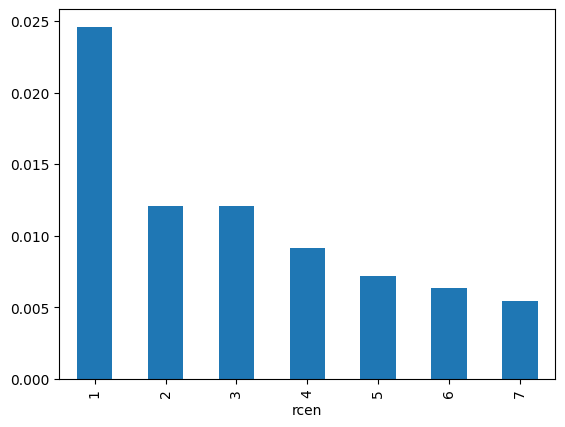

In [79]:
rcen_df = pd.crosstab(index=tar_df["rcen"], columns=tar_df["pv_flag"]).rename(columns={0: "neg", 1: "pos"})
rcen_df["N"] = rcen_df["neg"] + rcen_df["pos"]
rcen_df["prob"] = rcen_df["pos"] / rcen_df["N"]
rcen_df["prob"].plot.bar()

<Axes: xlabel='freq'>

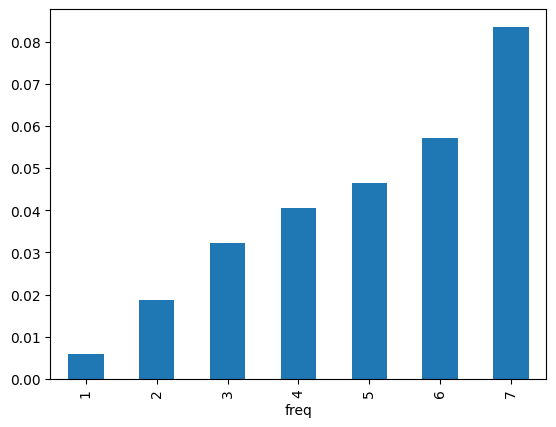

In [80]:
freq_df = pd.crosstab(index=tar_df["freq"], columns=tar_df["pv_flag"]).rename(columns={0: "neg", 1: "pos"})
freq_df["N"] = freq_df["neg"] + freq_df["pos"]
freq_df["prob"] = freq_df["pos"] / freq_df["N"]
freq_df["prob"].plot.bar()

In [81]:
# 最新度(rcen)と頻度(freq)に対する総件数と再閲覧件数の算出
RF2N = {}
RF2PV = {}
for row in tar_df.itertuples():
    RF2N.setdefault((row.rcen, row.freq), 0)
    RF2PV.setdefault((row.rcen, row.freq), 0)
    RF2N[row.rcen, row.freq] += 1
    if row.pv_flag == 1:
        RF2PV[row.rcen, row.freq] += 1

In [82]:
# 最新度(rcen)と頻度(freq)に対する再閲覧確率の算出
RF2Prob = {}
for rf, N in RF2N.items():
    RF2Prob[rf] = RF2PV[rf] / N

In [83]:
# 最新度(rcen)と頻度(freq)に対して総件数、再閲覧件数、再閲覧確率を対応付けるデータの作成
Rows3 = []
for rf, N in sorted(RF2N.items()):
    pv = RF2PV[rf]
    prob = RF2Prob[rf]
    row = (rf[0], rf[1], N, pv, prob)
    Rows3.append(row)
rf_df = pd.DataFrame(Rows3, columns = ['rcen', 'freq', 'N', 'pv', 'prob'])
print(len(rf_df))
rf_df.head()

49


,rcen,freq,N,pv,prob
0,1,1,19602,245,0.012499
1,1,2,3323,132,0.039723
2,1,3,1120,81,0.072321
3,1,4,539,36,0.066790
4,1,5,285,36,0.126316


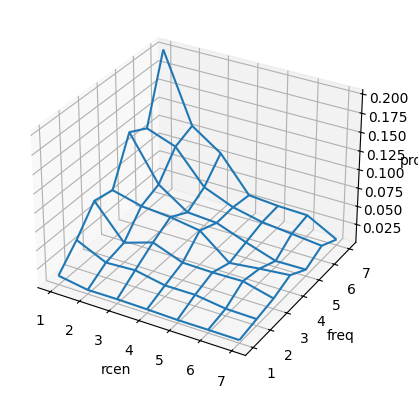

In [85]:
import matplotlib.pylab as plt

# 最新度(rcen)と頻度(freq)に対して再閲覧確率を対応付ける3Dグラフの作成
Freq = rf_df['freq'].unique().tolist()
Rcen = rf_df['rcen'].unique().tolist()
Z = [rf_df[(rf_df['freq']==freq) & (rf_df['rcen']==rcen)]['prob'].iloc[0] for freq in Freq for rcen in Rcen]
Z = np.array(Z).reshape((len(Freq), len(Rcen)))
X, Y = np.meshgrid(Rcen, Freq)  
fig = plt.figure()
ax = fig.add_subplot(111
                     , projection="3d"
                     , xlabel='rcen'
                     , ylabel='freq'
                     , zlabel='prob'
                    )
ax.plot_wireframe(X, Y, Z)

In [86]:
# 最新度(rcen)と頻度(freq)に対する総件数と再閲覧件数の算出
RF2N = {}
RF2PV = {}
for row in tar_df.itertuples():
    RF2N.setdefault((row.rcen, row.freq), 0)
    RF2PV.setdefault((row.rcen, row.freq), 0)
    RF2N[row.rcen, row.freq] += 1
    if row.pv_flag == 1:
        RF2PV[row.rcen,row.freq] += 1

In [90]:
# 最新度(rcen)と頻度(freq)に対する再閲覧確率の算出
RF2Prob = {}
for rf, N in RF2N.items():
    RF2Prob[rf] = RF2PV[rf] / N

In [91]:
R = sorted(tar_df["rcen"].unique().tolist())
F = sorted(tar_df["freq"].unique().tolist())

Idx = []
idx = 0
RF2Idx = {}
for r in R:
    for f in F:
        RF2Idx[r, f] = idx
        Idx.append(idx)
        idx += 1


print(RF2Idx)

G_list = []
h_list = []
var_vec = [0.0] * len(Idx)

for r in R:
    for f in F:
        idx = RF2Idx[r, f]
        G_row = var_vec[:]
        G_row[idx] = -1
        G_list.append(G_row)
        h_list.append(0)

for r in R:
    for f in F:
        idx = RF2Idx[r, f]
        G_row = var_vec[:]
        G_row[idx] = 1
        G_list.append(G_row)
        h_list.append(1)

for r in R[:-1]:
    for f in F:
        idx1 = RF2Idx[r, f]
        idx2 = RF2Idx[r+1, f]
        G_row = var_vec[:]
        G_row[idx1] = -1
        G_row[idx2] = 1
        G_list.append(G_row)
        h_list.append(0)

for r in R:
    for f in F[:-1]:
        idx1 = RF2Idx[r, f]
        idx2 = RF2Idx[r, f+1]
        G_row = var_vec[:]
        G_row[idx1] = 1
        G_row[idx2] = -1
        G_list.append(G_row)
        h_list.append(0)

P_list = []
q_list = []
for r in R:
    for f in F:
        idx = RF2Idx[r, f]
        N = RF2N[r, f]
        prob = RF2Prob[r, f]
        P_row = var_vec[:]
        P_row[idx] = 2 * N
        P_list.append(P_row)
        q_list.append(-2 * N * prob)

{(1, 1): 0, (1, 2): 1, (1, 3): 2, (1, 4): 3, (1, 5): 4, (1, 6): 5, (1, 7): 6, (2, 1): 7, (2, 2): 8, (2, 3): 9, (2, 4): 10, (2, 5): 11, (2, 6): 12, (2, 7): 13, (3, 1): 14, (3, 2): 15, (3, 3): 16, (3, 4): 17, (3, 5): 18, (3, 6): 19, (3, 7): 20, (4, 1): 21, (4, 2): 22, (4, 3): 23, (4, 4): 24, (4, 5): 25, (4, 6): 26, (4, 7): 27, (5, 1): 28, (5, 2): 29, (5, 3): 30, (5, 4): 31, (5, 5): 32, (5, 6): 33, (5, 7): 34, (6, 1): 35, (6, 2): 36, (6, 3): 37, (6, 4): 38, (6, 5): 39, (6, 6): 40, (6, 7): 41, (7, 1): 42, (7, 2): 43, (7, 3): 44, (7, 4): 45, (7, 5): 46, (7, 6): 47, (7, 7): 48}


In [93]:
import cvxopt

In [94]:
G = cvxopt.matrix(np.array(G_list), tc="d")
h = cvxopt.matrix(np.array(h_list), tc="d")
P = cvxopt.matrix(np.array(P_list), tc="d")
q = cvxopt.matrix(np.array(q_list), tc="d")

sol = cvxopt.solvers.qp(P, q, G, h)

     pcost       dcost       gap    pres   dres
 0: -6.9036e+01 -1.2333e+02  4e+02  2e+00  1e-02
 1: -6.8921e+01 -8.7883e+01  3e+01  5e-02  3e-04
 2: -6.8908e+01 -7.6998e+01  1e+01  2e-02  9e-05
 3: -6.8653e+01 -7.1275e+01  3e+00  2e-03  1e-05
 4: -6.8718e+01 -6.9029e+01  3e-01  2e-04  1e-06
 5: -6.8733e+01 -6.8753e+01  2e-02  1e-05  6e-08
 6: -6.8734e+01 -6.8735e+01  5e-04  2e-07  1e-09
 7: -6.8735e+01 -6.8735e+01  9e-06  2e-09  1e-11
Optimal solution found.


In [98]:
RF2PredProb = {}
x = sol['x']
for r in R:
    for f in F:
        idx = RF2Idx[r, f]
        pred_prob = x[idx]
        RF2PredProb[r, f] = pred_prob

rf_df["pred_prob"] = rf_df.apply(lambda x: RF2PredProb[x["rcen"], x["freq"]], axis=1)

In [99]:
rf_df.head()

,rcen,freq,N,pv,prob,pred_prob
0,1,1,19602,245,0.012499,0.012499
1,1,2,3323,132,0.039723,0.039723
2,1,3,1120,81,0.072321,0.070524
3,1,4,539,36,0.066790,0.070524
4,1,5,285,36,0.126316,0.121212
